# Práctica 13: Análisis de imagenes

Uno de los campos con mayor interés es el de visión computacional debido a la gran cantidad de aplicaciones que están enfocadas con el reconocimiento y seguimiento de objetos. La razón de esto es simple, la visión es de las principales formas de interacción y aprendizaje con el mundo que nos rodea. Actualmente existen una gran cantidad de librerías y complementos que permiten trabajar con datos en forma de imágenes o videos (compuesto de imágenes), pero en este caso solo se hará uso de la librería [Pillow]( https://pillow.readthedocs.io/en/stable/).

Nuestro caso de estudio para esta practica es una imagen de un partido de futbol soccer y el objetivo es poder identificar cada uno de los jugadores sin importar el equipo. Empezamos cargando la imagen.


(822, 166)


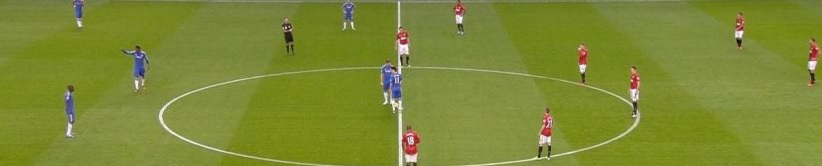

In [422]:
from __future__ import print_function
import binascii
import struct
from PIL import Image
import numpy as np
import scipy
import scipy.misc
import scipy.cluster

imagen = Image.open("cancha.jpg") 
print(imagen.size)
data = np.array(imagen)
imagen

In [199]:
w=822
h=166

Afortunadamente los colores de los uniformes contrastan con el color del césped. Para poder eliminar el césped se basa en la idea de caracterizar los colores de los uniformes para eliminar todo lo demás, por lo tanto, se toman **dos muestras** de la imagen una donde aparezca el **uniforme azul** y la otra donde aparezca el **uniforme rojo**. Estas dos muestras son **sometidas a un algoritmo de clasificación de dos grupos para obtener los colores promedio del uniforme y el césped**, de modo que los colores RGB del césped aparecerá en ambas muestras y los restantes serán los promedios para cada uniforme respectivamente. 

In [425]:
from sklearn.cluster import KMeans
crop_rectangle1 = (130, 60, 150, 75)
chelsea = imagen.crop(crop_rectangle1)
chelsea_rgb = np.array(chelsea)
chelsea_rgb=np.reshape(chelsea_rgb,(chelsea.size[0]*chelsea.size[1],3))
estimador=KMeans(init='k-means++', n_clusters=2, n_init=10)  
estimador.fit(chelsea_rgb)
g=estimador.cluster_centers_
print(g)
chelsea

[[ 69.60666667  79.82666667 129.83333333]
 [120.34666667 130.08666667  86.        ]]


Es fácil identificar que la primera lista corresponde a los colores promedio del **uniforme azul** porque la **tercera componente que representa el color azul** es la más fuerte.

In [426]:
crop_rectangle2 = (570, 49, 590, 65)
manu = imagen.crop(crop_rectangle2)
manu_rgb = np.array(manu)
manu_rgb=np.reshape(manu_rgb,(manu.size[0]*manu.size[1],3))
estimador=KMeans(init='k-means++', n_clusters=2, n_init=10)  
estimador.fit(manu_rgb)
g=estimador.cluster_centers_
print(g)
manu

[[164.85211268  85.52816901  63.26760563]
 [124.20224719 128.74719101  36.17977528]]


Igual que en el caso anterior es fácil identificar que la primera lista de colores promedio es del **uniforme rojo** porque la **primera componente que representa el color rojo** es la más fuerte.

En ambos análisis la lista de colores promedio restante está entre [124-120,130-128,80-30]. El uniforme rojo tiene una componente promedio del rojo de 164 y el uniforme azul tiene una componente promedio del rojo de 70, eso quiere decir que cualquier color entre estos valores no es rojo ni azul como el césped que esta entre 124 o 130. Lo anterior se utiliza para escribir un script que todo aquel color que no es rojo ni azul sea cambiado a blanco.

131777


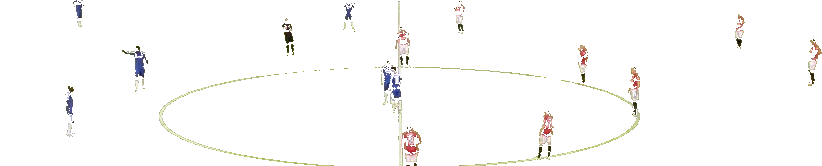

In [393]:
copy=data[:,:,:]
c=0
for i in range(h):
    for j in range(w):
        colores=copy[i,j]
        if colores[0]>90 and colores[0]<160:
            copy[i,j]=[255,255,255]
            c=c+1
#print(copy)
im = Image.fromarray(copy)
#im=im.convert("1")
print(c)
#data1=np.array(im)
#print(data1)
im

Se observa que el **césped prácticamente ha desaparecido** pero aún están presentes las líneas que marcan los límites de la cancha y algunas partes de los jugadores también han desaparecido, pero **siguen teniendo estructura**. Lo siguiente será dividir la imagen en cuadros de tamaño 20 x 40. La idea para poder identificar si hay o no un jugador es obtener una relación de **cuantos puntos son blancos** para tener un estimado de la **densidad de puntos que tienen color** y de esta forma **identificar que hay un jugador en ese cuadro**.

13


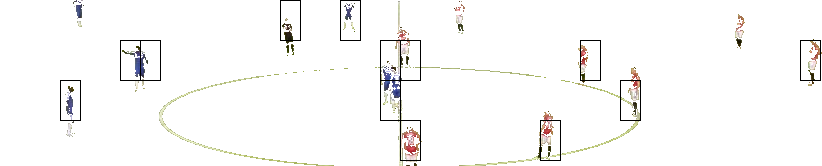

In [378]:
from PIL import ImageDraw
draw = ImageDraw.Draw(im)
c=0
m=20
n=40
for i in range(0,h-n,n):
    for j in range(0,w-m,m):
        crop_rectangle = (j, i, j+m, i+n)
        rectangle = im.crop(crop_rectangle)
        rectangle_rgb = np.array(rectangle)
        blancos=0
        for k in range(m):
            for l in range(n):
                if rectangle_rgb[l,k,0]>230 and rectangle_rgb[l,k,1]>230 and rectangle_rgb[l,k,2]>230:
                    blancos=blancos+1
        #print(blancos)
        if blancos<700:
            draw.rectangle([j,i,j+m,i+n], outline="black")
            c=c+1
print(c)
im

Los resultados son que con esta técnica **si es posible identificar** si existe un jugador en casa cuadro, aunque los cuadros **no están centrados** al jugador y si se aumenta que la cantidad de puntos blancos se empiezan a **identificar las líneas de la cancha** como si fueran jugadores. Para evitar el problema de las líneas se hará lo mismo que con los uniformes para obtener los colores promedio que caracterizan las líneas y después se eliminaran.

In [399]:
crop_rectangle1 = (150, 100, 180, 140)
linea = im.crop(crop_rectangle1)
linea = np.array(linea)
linea=np.reshape(linea,(linea.shape[0]*linea.shape[1],3))
linea
estimador=KMeans(init='k-means++', n_clusters=2, n_init=10)  
estimador.fit(linea)
estimador.cluster_centers_

array([[254.80131827, 254.8700565 , 254.33992467],
       [206.74637681, 212.69565217, 170.39130435]])

0


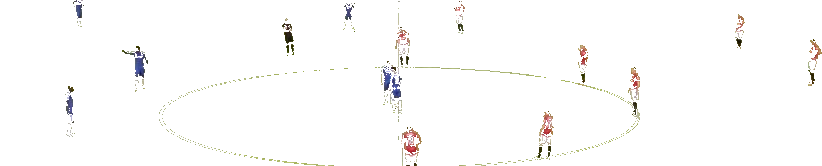

In [418]:
copy=data[:,:,:]
c=0
for i in range(h):
    for j in range(w):
        colores=copy[i,j]
        if colores[0]>90 and colores[0]<160:
            copy[i,j]=[255,255,255]
            c=c+1
        if colores[1]>200:
            copy[i,j]=[255,255,255]
#print(copy)
im = Image.fromarray(copy)
#im=im.convert("1")
print(c)
#data1=np.array(im)
#print(data1)
im

La imagen obtenida tiene **mayor abundancia de color blanco en las líneas de la cancha**. Con el objetivo de refinar la identificación de un jugador se utilizará un **cuadro de tamaño más pequeño**.

58


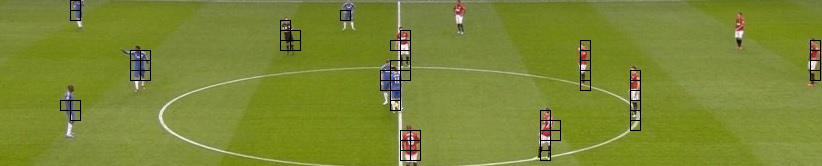

In [421]:
from PIL import ImageDraw
draw = ImageDraw.Draw(imagen)
draw1 = ImageDraw.Draw(im)
c=0
m=10
n=10
for i in range(0,h-n,n):
    for j in range(0,w-m,m):
        crop_rectangle = (j, i, j+m, i+n)
        rectangle = im.crop(crop_rectangle)
        rectangle_rgb = np.array(rectangle)
        blancos=0
        for k in range(m):
            for l in range(n):
                if rectangle_rgb[l,k,0]>230 and rectangle_rgb[l,k,1]>230 and rectangle_rgb[l,k,2]>230:
                    blancos=blancos+1
        #print(blancos)
        if blancos<80:
            draw.rectangle([j,i,j+m,i+n], outline="black")
            draw1.rectangle([j,i,j+m,i+n], outline="black")
            c=c+1
print(c)
imagen

Como se observa la imagen final obtenida muestra los cuadros que identifican a los jugadores, aunque estos no son precisamente cuadros. Es importante mencionar que no todos los jugadores fueron identificados.
Falta mucho que se puede hacer con esta imagen, como realmente tener un cuadro por cada jugador y centrado, para después poderles dar seguimiento en un video.
